Install library : 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets
!pip install transformers
!pip install -q sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 13.9 MB/s 
     |████████████████████████████████| 1.1 MB 65.3 MB/s 
     |████████████████████████████████| 101 kB 13.9 MB/s 
     |████████████████████████████████| 212 kB 71.7 MB/s 
     |████████████████████████████████| 140 kB 57.4 MB/s 
     |████████████████████████████████| 596 kB 68.4 MB/s 
     |████████████████████████████████| 127 kB 76.7 MB/s 
     |████████████████████████████████| 144 kB 75.3 MB/s 
     |████████████████████████████████| 94 kB 2.4 MB/s 
     |████████████████████████████████| 271 kB 74.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's de

Import library : 

In [3]:
from huggingface_hub import notebook_login

# load dataset library : 
from datasets import load_dataset, load_metric,DatasetDict

# transformers 
import transformers
from transformers import AutoTokenizer,default_data_collator
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer


import collections


In [4]:
notebook_login()

!apt install git-lfs


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


Loading data set ....

In [5]:
 
dataset = load_dataset('json', data_files={'train': '/content/drive/MyDrive/NLP_CA6/new_jsonfile/pquad_public/train_samples.json', 
                                            'test': '/content/drive/MyDrive/NLP_CA6/new_jsonfile/PersianQA/pqa_test.json'}, field="data")
dataset

Using custom data configuration default-9bc8b962205feb9a


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-9bc8b962205feb9a/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'answers', 'id', 'question'],
        num_rows: 690
    })
    test: Dataset({
        features: ['title', 'context', 'answers', 'id', 'question'],
        num_rows: 651
    })
})

Test / Train / Valiataion split : 

In [6]:

# # Split the 10% test + valid in half test, half valid
test_valid = dataset['train'].train_test_split(test_size=0.05)
# # gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = DatasetDict({
    'train': test_valid['train'],
    'test': dataset['test'],
    'validation': test_valid['test']})
train_test_valid_dataset


DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'answers', 'id', 'question'],
        num_rows: 655
    })
    test: Dataset({
        features: ['title', 'context', 'answers', 'id', 'question'],
        num_rows: 651
    })
    validation: Dataset({
        features: ['title', 'context', 'answers', 'id', 'question'],
        num_rows: 35
    })
})

In [7]:
# just for PasrQuAD dataset : 

# train_test_valid_dataset = dataset

Parameter : 

In [8]:
squad_v2 = False
model_name = "m3hrdadfi/albert-fa-base-v2"
# 
# "m3hrdadfi/albert-fa-base-v2"
# "HooshvareLab/bert-base-parsbert-uncased"
batch_size = 16
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.



Tokenizer : 

In [9]:

tokenizer = AutoTokenizer.from_pretrained(model_name)


pad_on_right = tokenizer.padding_side == "right"

assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

In [10]:
def data_tokenization(examples):

    examples["question"] = [q.lstrip() for q in examples["question"]]


    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )


    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [11]:
tokenized_datasets = train_test_valid_dataset.map(data_tokenization, batched=True, remove_columns=train_test_valid_dataset["train"].column_names)


Parameter 'function'=<function data_tokenization at 0x7fd16859e440> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [12]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 655
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 651
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 35
    })
})

Model for Question Answering :

In [13]:

model = AutoModelForQuestionAnswering.from_pretrained(model_name)

Downloading:   0%|          | 0.00/69.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at m3hrdadfi/albert-fa-base-v2 were not used when initializing AlbertForQuestionAnswering: ['predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'sop_classifier.classifier.weight', 'sop_classifier.classifier.bias', 'predictions.dense.bias', 'predictions.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForQuestionAnswering were not initialized from the model checkpoint at m3hrdadfi/albert-fa-base-v2

In [14]:
model_name = model_name.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-squad",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

In [15]:

data_collator = default_data_collator

In [16]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

Cloning https://huggingface.co/mhmsadegh/albert-fa-base-v2-finetuned-squad into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.58k/66.7M [00:00<?, ?B/s]

Download file runs/Jun22_08-59-28_704fff7ce727/events.out.tfevents.1655888373.704fff7ce727.71.2:  76%|#######6…

Download file spiece.model:   0%|          | 3.48k/1.80M [00:00<?, ?B/s]

Download file training_args.bin:  57%|#####6    | 1.84k/3.23k [00:00<?, ?B/s]

Download file runs/Jun22_08-59-28_704fff7ce727/1655888373.7559159/events.out.tfevents.1655888373.704fff7ce727.…

Clean file runs/Jun22_08-59-28_704fff7ce727/events.out.tfevents.1655888373.704fff7ce727.71.2:  22%|##1       |…

Clean file runs/Jun22_08-59-28_704fff7ce727/1655888373.7559159/events.out.tfevents.1655888373.704fff7ce727.71.…

Clean file training_args.bin:  31%|###       | 1.00k/3.23k [00:00<?, ?B/s]

Clean file spiece.model:   0%|          | 1.00k/1.80M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/66.7M [00:00<?, ?B/s]

In [17]:
trainer.train()


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 655
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 123


Epoch,Training Loss,Validation Loss
1,No log,3.816089
2,No log,3.149745
3,No log,2.819643


***** Running Evaluation *****
  Num examples = 35
  Batch size = 16
***** Running Evaluation *****
  Num examples = 35
  Batch size = 16
***** Running Evaluation *****
  Num examples = 35
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=123, training_loss=3.3412726177432672, metrics={'train_runtime': 141.2171, 'train_samples_per_second': 13.915, 'train_steps_per_second': 0.871, 'total_flos': 32546004871680.0, 'train_loss': 3.3412726177432672, 'epoch': 3.0})

Model Evaluation : 

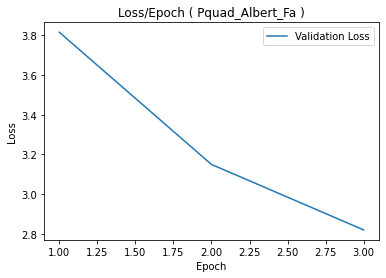

In [18]:
import matplotlib.pyplot as plt
epoch_list = [1,2,3]
# train_loss = [3.10600,2.96,1.740100]
val_loss = [3.8160890,3.149745,2.819643] 
plt.plot(epoch_list,val_loss,label="Validation Loss")
# plt.plot(epoch_list,train_loss,label="Train Loss")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss/Epoch ( Pquad_Albert_Fa )")
plt.show()

In [19]:
def prepare_test_features(examples):

    examples["question"] = [q.lstrip() for q in examples["question"]]

    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )


    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [20]:

test_features = train_test_valid_dataset["test"].map(
    prepare_test_features,
    batched=True,
    remove_columns=train_test_valid_dataset["test"].column_names
)

test_features.set_format(type=test_features.format["type"], columns=list(test_features.features.keys()))


  0%|          | 0/1 [00:00<?, ?ba/s]

In [21]:
test_features = train_test_valid_dataset["test"].map(
    prepare_test_features,
    batched=True,
    remove_columns=train_test_valid_dataset["test"].column_names
)


test_features.set_format(type=test_features.format["type"], columns=list(test_features.features.keys()))


  0%|          | 0/1 [00:00<?, ?ba/s]

In [22]:
test_features


Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 651
})

Test prediction : 

In [23]:
test_pred = trainer.predict(test_features)


The following columns in the test set don't have a corresponding argument in `AlbertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id. If offset_mapping, example_id are not expected by `AlbertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 651
  Batch size = 16


In [24]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    print(features)
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")
    
    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]
        
        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

In [25]:
import numpy as np
final_predictions = postprocess_qa_predictions(train_test_valid_dataset["test"], test_features, test_pred.predictions)


Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 651
})
Post-processing 651 example predictions split into 651 features.


  0%|          | 0/651 [00:00<?, ?it/s]

In [26]:
metric = load_metric("squad_v2" if squad_v2 else "squad")


if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in train_test_valid_dataset["test"]]


Result on PersianQA test dataset :

In [27]:
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 12.442396313364055, 'f1': 28.966864843739366}

In [28]:
 
dataset1 = load_dataset('json', data_files='/content/drive/MyDrive/NLP_CA6/new_jsonfile/pquad_public/test_samples.json', field="data")
dataset1

Using custom data configuration default-ad060765033d20f8


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-ad060765033d20f8/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'answers', 'id', 'question'],
        num_rows: 95
    })
})

In [29]:
pquad_test_tokenized = dataset1.map(data_tokenization, batched=True, remove_columns=dataset1["train"].column_names)


  0%|          | 0/1 [00:00<?, ?ba/s]

In [30]:
test_features = dataset1["train"].map(
    prepare_test_features,
    batched=True,
    remove_columns=dataset1["train"].column_names
)

test_features.set_format(type=test_features.format["type"], columns=list(test_features.features.keys()))


  0%|          | 0/1 [00:00<?, ?ba/s]

In [31]:
test_pred = trainer.predict(test_features)


The following columns in the test set don't have a corresponding argument in `AlbertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id. If offset_mapping, example_id are not expected by `AlbertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 95
  Batch size = 16


In [32]:
import numpy as np
final_predictions = postprocess_qa_predictions(dataset1["train"], test_features, test_pred.predictions)


Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 95
})
Post-processing 95 example predictions split into 95 features.


  0%|          | 0/95 [00:00<?, ?it/s]

In [33]:
metric = load_metric("squad_v2" if squad_v2 else "squad")


if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in dataset1["train"]]

Test on pquad test dataset(Train on PersianQA: dataset): 

In [34]:
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 18.94736842105263, 'f1': 38.36511967564599}

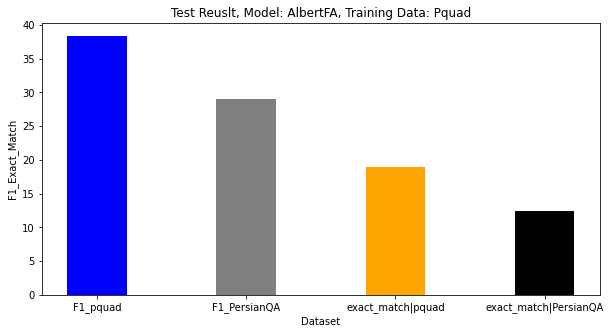

In [36]:
import numpy as np
import matplotlib.pyplot as plt
# creating the dataset


data = {'F1_pquad':38.36, 'F1_PersianQA':28.96, 'exact_match|pquad':18.94,
        'exact_match|PersianQA':12.44}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color =['blue','gray','orange','black'],
        width = 0.4)
 
plt.xlabel("Dataset")
plt.ylabel("F1_Exact_Match")
plt.title("Test Reuslt, Model: AlbertFA, Training Data: Pquad")
plt.show()